<h1 align="center">CS 4058 – Data Warehousing and Data Mining 
Fall 2024 – Proje</h1I

<h2 align="center">User-User Collaborative Jokes Recommender System</h2>

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Step 1: Load Dataset


In [25]:
print("Loading dataset...")
file_path = 'FINAL jester 2006-15.xls'  # Replace with correct file path
data = pd.read_excel(file_path, header=None, engine='xlrd')

Loading dataset...


In [27]:
data.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
31021,11,99,99,99,99,99.0,99,4.06250,5.00000,99,...,99.0,99.0,99.00000,99.0,99.00000,99.0,99.00000,99.0000,99.0,99.00000
34534,57,99,99,99,99,99.0,99,-8.21875,-7.46875,99,...,99.0,99.0,-0.53125,99.0,1.65625,99.0,1.59375,0.0625,99.0,3.53125
15842,10,99,99,99,99,99.0,99,-5.93750,2.03125,99,...,99.0,99.0,99.00000,99.0,99.00000,99.0,99.00000,99.0000,99.0,99.00000


# Step 2: Data Preprocessing


In [30]:
print("Preprocessing dataset...")
# Replace 99 (null ratings) with NaN
data.replace(99, np.nan, inplace=True)
# Remove users with very few ratings (threshold = 10)
data_clean = data.dropna(thresh=10)

print(f"Dataset Shape after Cleaning: {data_clean.shape}")


Preprocessing dataset...
Dataset Shape after Cleaning: (46625, 151)


# Visualization 1: Distribution of ratings


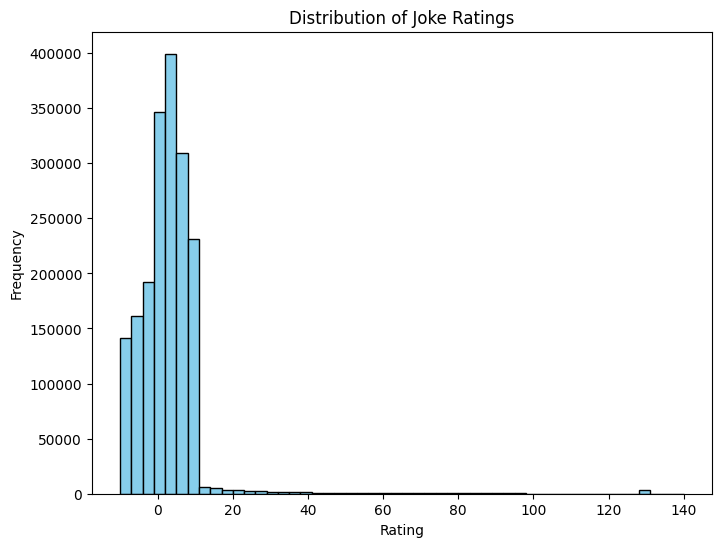

In [33]:
# Visualization 1: Distribution of ratings
plt.figure(figsize=(8, 6))
plt.hist(data_clean.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Joke Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


# Step 3: Focus on Top 2K Active Users


In [36]:
print("Selecting top 2000 most active users...")
user_ratings_count = data_clean.count(axis=1)
top_users = user_ratings_count.nlargest(2000).index
data_top_users = data_clean.loc[top_users]

print(f"Top Users Shape: {data_top_users.shape}")

Selecting top 2000 most active users...
Top Users Shape: (2000, 151)


# Visualization 2: User activity (top 20 users)


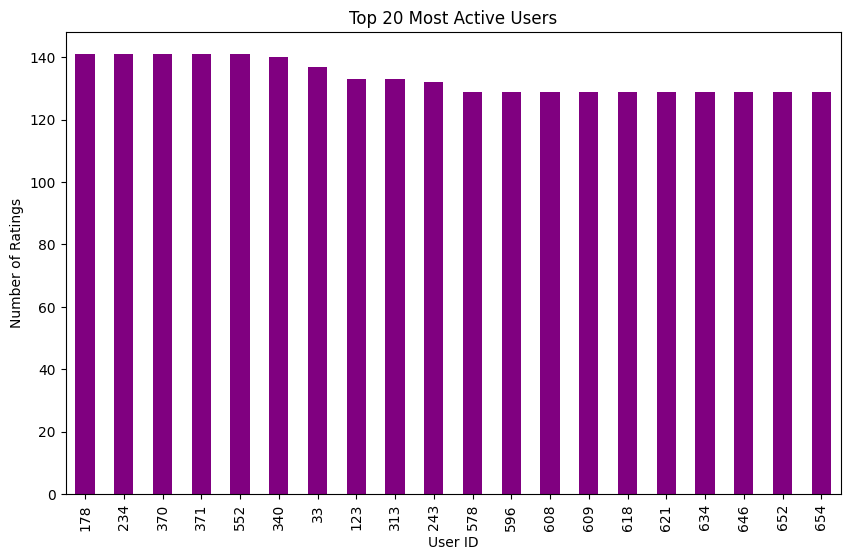

In [43]:
plt.figure(figsize=(10, 6))
user_ratings_count[top_users].nlargest(20).plot(kind='bar', color='purple')
plt.title("Top 20 Most Active Users")
plt.xlabel("User ID")
plt.ylabel("Number of Ratings")
plt.show()

# Step 4: Train-Test Split (80-20)


In [50]:
print("Splitting dataset into train and test...")
train_data = data_top_users.copy()
test_data = pd.DataFrame(np.nan, index=train_data.index, columns=train_data.columns)


Splitting dataset into train and test...


# Randomly mask 20% of the ratings in test set


In [53]:
for user in train_data.index:
    rated_jokes = train_data.loc[user].dropna().index
    test_jokes = random.sample(list(rated_jokes), int(0.2 * len(rated_jokes)))
    test_data.loc[user, test_jokes] = train_data.loc[user, test_jokes]
    train_data.loc[user, test_jokes] = np.nan

# Visualization 3: Sparsity of ratings


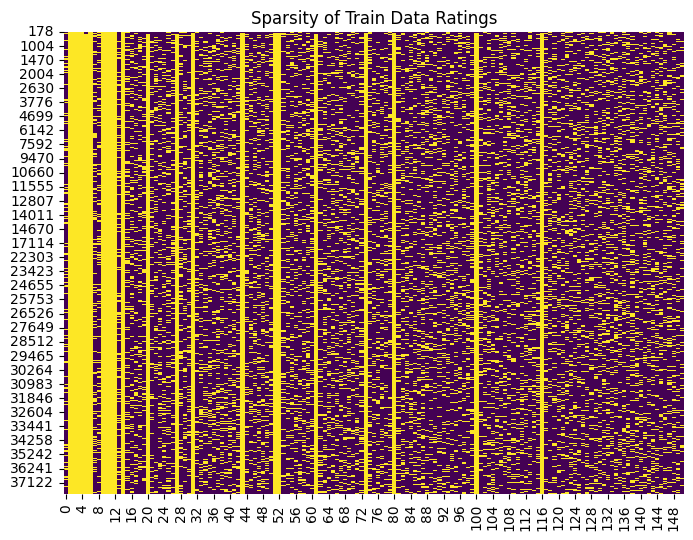

In [56]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_data.isna(), cbar=False, cmap='viridis')
plt.title("Sparsity of Train Data Ratings")
plt.show()

# Step 5: Compute User-User Similarity


In [59]:
print("Calculating user-user similarity...")
user_similarity = cosine_similarity(train_data.fillna(0))
np.fill_diagonal(user_similarity, 0)
similarity_df = pd.DataFrame(user_similarity, index=train_data.index, columns=train_data.index)

Calculating user-user similarity...


# Visualization 4: User similarity heatmap (subset of users)


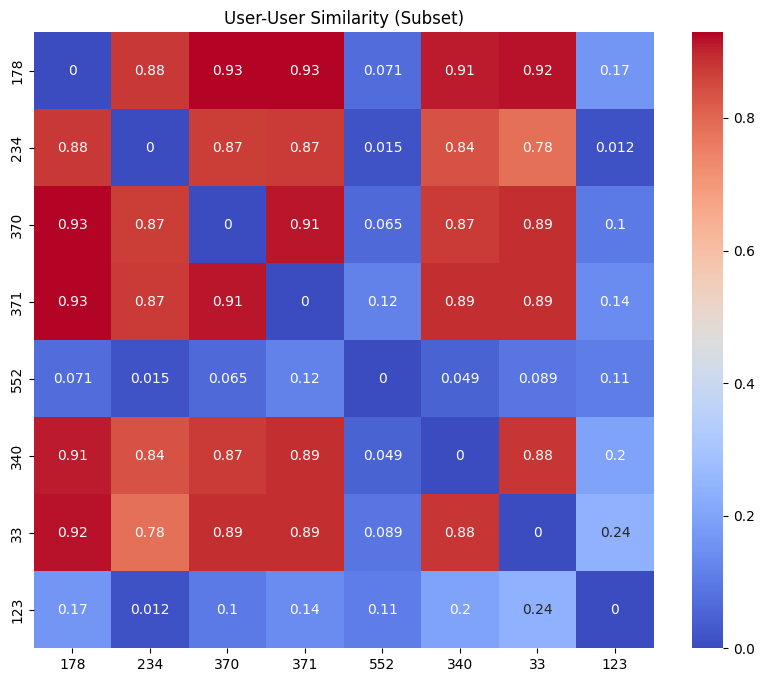

In [71]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df.iloc[:8, :8], cmap="coolwarm", annot=True)
plt.title("User-User Similarity (Subset)")
plt.show()


# Step 6: Predict Ratings based on K Similar Users


In [352]:
def predict_ratings(user_id, k):
    """
    Predict ratings for a user based on K-most similar users.
    """
    similar_users = similarity_df.loc[user_id].nlargest(k).index
    weights = similarity_df.loc[user_id, similar_users]
    ratings = train_data.loc[similar_users]
    weighted_ratings = ratings.multiply(weights, axis=0).sum(skipna=True)
    normalization = weights.sum()
    return weighted_ratings / normalization if normalization > 0 else None

print("Predicting ratings...")
k_values = [5, 10, 20]
best_mae = float('inf')
best_k = 0
mae_values = []

for k in k_values:
    predictions = []
    true_values = []
    for user in test_data.index:
        user_pred = predict_ratings(user, k)
        if user_pred is not None:
            for joke in test_data.columns:
                if not np.isnan(test_data.loc[user, joke]):
                    predictions.append(user_pred[joke])
                    true_values.append(test_data.loc[user, joke])
    mae = mean_absolute_error(true_values, predictions)
    mae_values.append(mae)
    print(f"K={k}, MAE={mae:.4f}")
    if mae < best_mae:
        best_mae = mae
        best_k = k

Predicting ratings...
K=5, MAE=4.5334
K=10, MAE=4.5052
K=20, MAE=4.4982


# Visualization 5: MAE vs. K


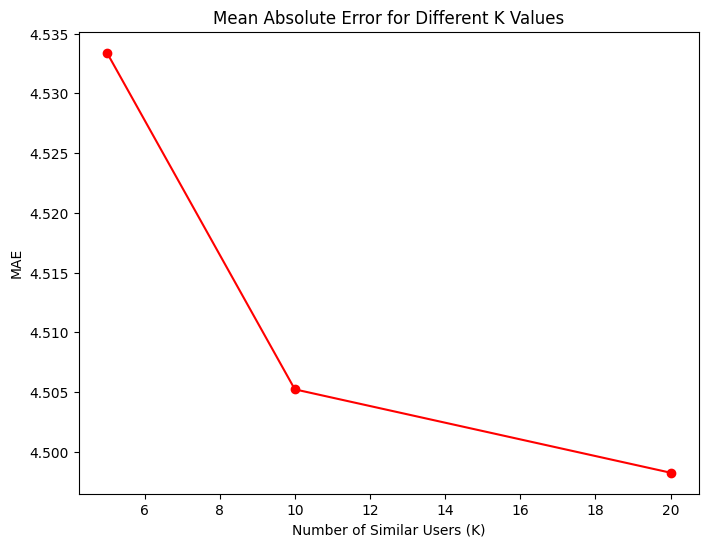

Best K: 20, Best MAE: 4.4982


In [357]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, mae_values, marker='o', color='red')
plt.title("Mean Absolute Error for Different K Values")
plt.xlabel("Number of Similar Users (K)")
plt.ylabel("MAE")
plt.show()

print(f"Best K: {best_k}, Best MAE: {best_mae:.4f}")

# random_recommender

In [360]:

def random_recommender(test_set):
    """
    Randomly predict ratings using random users.
    """
    random_predictions = []
    random_true_values = []
    for user in test_set.index:
        random_users = random.sample(list(train_data.index), k=5)
        for joke in test_set.columns:
            if not np.isnan(test_set.loc[user, joke]):
                # Calculate the mean rating for this joke from the random users
                random_rating = train_data.loc[random_users, joke].mean(skipna=True)
                if not np.isnan(random_rating):  # Ensure no NaN values are added
                    random_predictions.append(random_rating)
                    random_true_values.append(test_set.loc[user, joke])
    
    # Ensure no NaN values in the lists before calculating MAE
    random_predictions = [pred for pred, true in zip(random_predictions, random_true_values) if not np.isnan(pred)]
    random_true_values = [true for true in random_true_values if not np.isnan(true)]
    
    return mean_absolute_error(random_true_values, random_predictions)

# Running the base random recommender again


In [363]:
print("Running base random recommender...")
random_mae = random_recommender(test_data)
print(f"MAE for Base Random Recommender: {random_mae:.4f}")

Running base random recommender...
MAE for Base Random Recommender: 4.4385


# Visualization 6: Train-Test Ratings


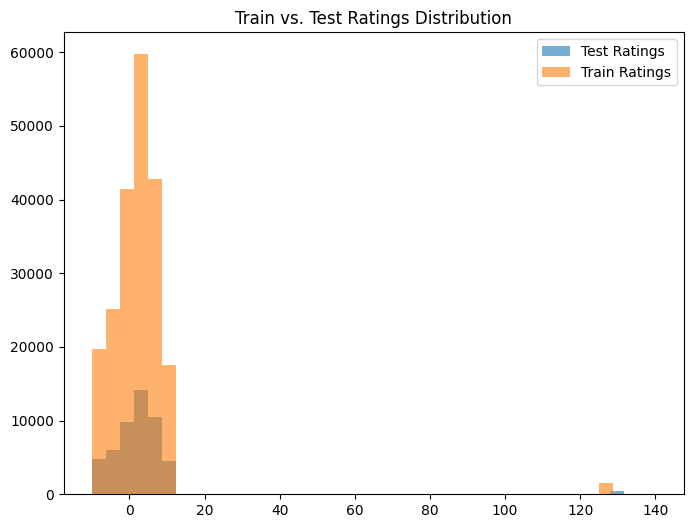

In [366]:
plt.figure(figsize=(8, 6))
plt.hist(test_data.values.flatten(), bins=40, alpha=0.6, label="Test Ratings")
plt.hist(train_data.values.flatten(), bins=40, alpha=0.6, label="Train Ratings")
plt.title("Train vs. Test Ratings Distribution")
plt.legend()
plt.show()


# Step 8: Comparison and Results


In [369]:
print("Final Results:")
print(f"Best K={best_k}, MAE for User-User Collaborative Filtering: {best_mae:.4f}")
print(f"MAE for Base Random Recommender: {random_mae:.4f}")


Final Results:
Best K=20, MAE for User-User Collaborative Filtering: 4.4982
MAE for Base Random Recommender: 4.4385


# Visualization 7: MAE Comparison


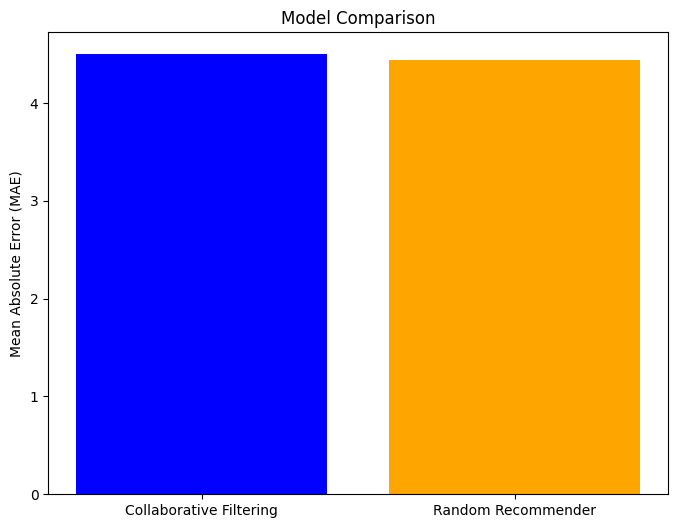

In [372]:
plt.figure(figsize=(8, 6))
plt.bar(['Collaborative Filtering', 'Random Recommender'], [best_mae, random_mae], color=['blue', 'orange'])
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Comparison')
plt.show()

# Visualization 8: Most Predicted Ratings


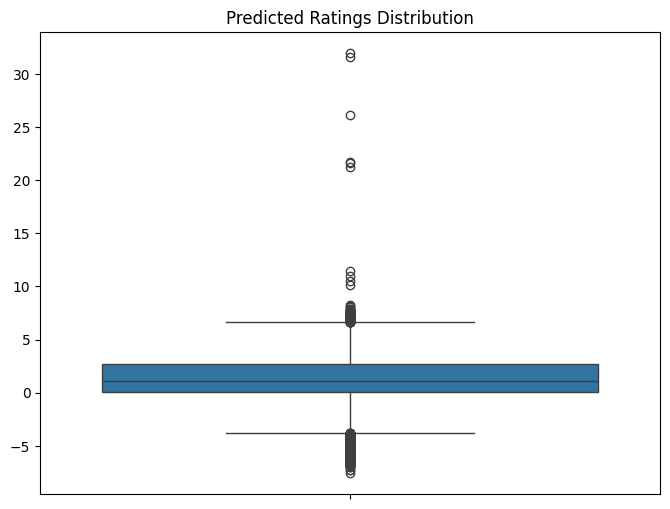

In [375]:
plt.figure(figsize=(8, 6))
sns.boxplot(predictions)
plt.title("Predicted Ratings Distribution")
plt.show()


# Visualization 9: Similarity Distribution


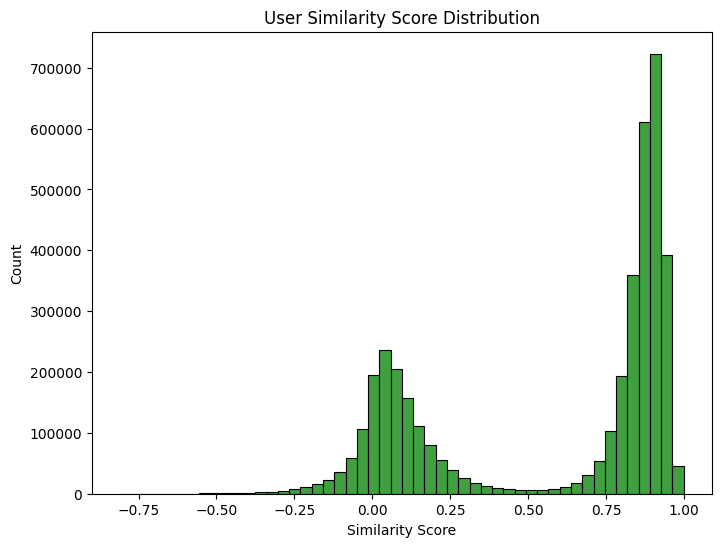

In [378]:
plt.figure(figsize=(8, 6))
sns.histplot(similarity_df.values.flatten(), bins=50, color='green')
plt.title("User Similarity Score Distribution")
plt.xlabel("Similarity Score")
plt.show()

# Visualization 10: Distribution of ratings per user


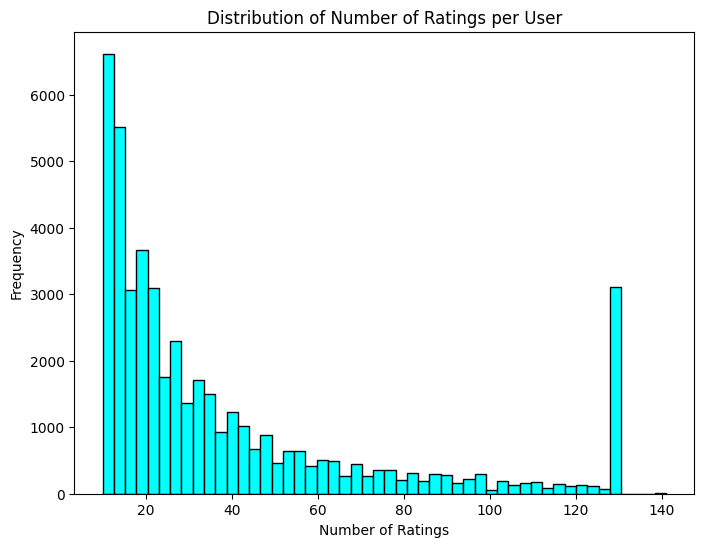

In [381]:
plt.figure(figsize=(8, 6))
user_rating_counts = data_clean.notna().sum(axis=1)
plt.hist(user_rating_counts, bins=50, color='cyan', edgecolor='black')
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()


# Visualization 11: Top 20 Most Rated Jokes


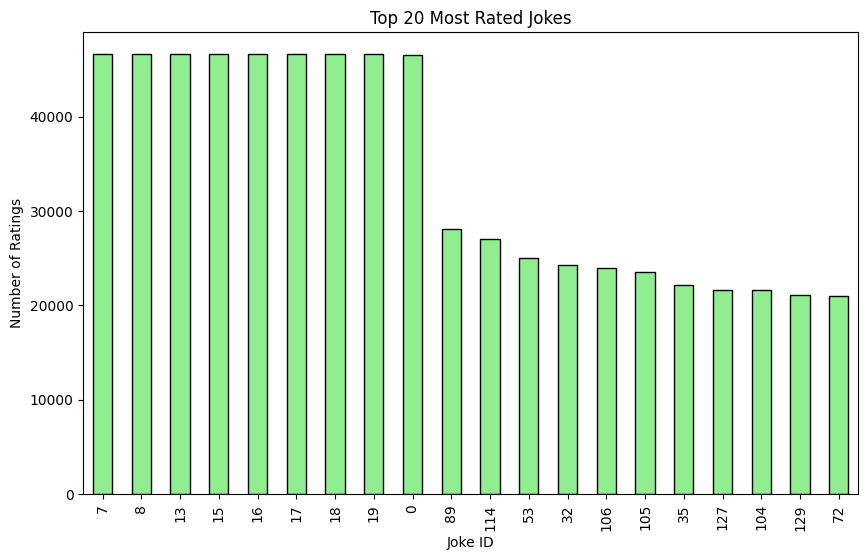

In [384]:
plt.figure(figsize=(10, 6))
joke_rating_counts = data_clean.notna().sum(axis=0)
top_20_jokes = joke_rating_counts.nlargest(20)
top_20_jokes.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Top 20 Most Rated Jokes")
plt.xlabel("Joke ID")
plt.ylabel("Number of Ratings")
plt.show()

# Visualization 12: Rating distribution density plot


C:\Users\FAST LAPTOP\AppData\Local\Temp\ipykernel_17880\3414482494.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_clean.values.flatten(), color='blue', shade=True)


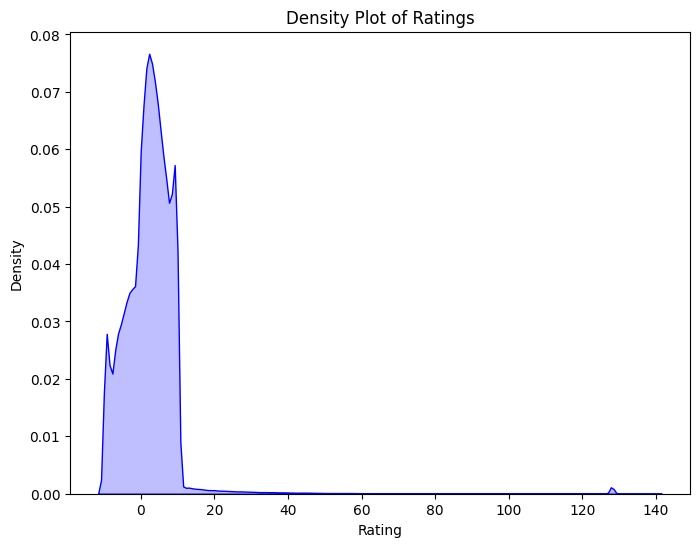

In [387]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data_clean.values.flatten(), color='blue', shade=True)
plt.title("Density Plot of Ratings")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.show()